In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import Wrapper 
from gymnasium.spaces import Box, Discrete, MultiDiscrete

from graph import *
from environment import *
from modules import *
from trainer import *

torch.manual_seed(0)
np.random.seed(0)

In [16]:
net = torch.load('results/net.pth')
data_training = pickle.load(open('results/data.p', 'rb'))

# net = torch.load('results_hidden_size/net_32_1.pth')
# data_training = pickle.load(open('results_hidden_size/data_32_1.p', 'rb'))

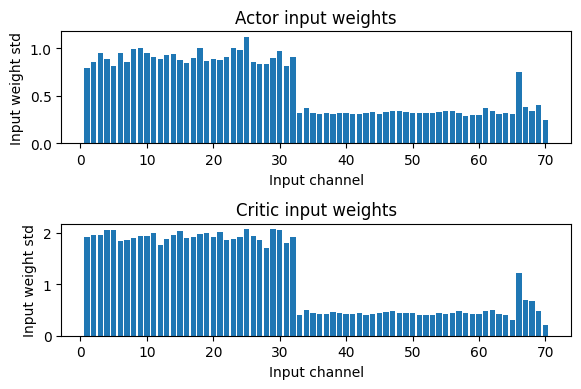

In [17]:
input_weights_sd_actor = net.lstm_actor.weight_ih.detach().numpy().std(axis = 0)
input_weights_sd_critic = net.lstm_critic.weight_ih.detach().numpy().std(axis = 0)

plt.figure(figsize = (6, 4))

plt.subplot(2, 1, 1)
plt.bar(range(1, len(input_weights_sd_actor) + 1), input_weights_sd_actor)
plt.title('Actor input weights')
plt.xlabel('Input channel')
plt.ylabel('Input weight std')

plt.subplot(2, 1, 2)
plt.bar(range(1, len(input_weights_sd_critic) + 1), input_weights_sd_critic)
plt.title('Critic input weights')
plt.xlabel('Input channel')
plt.ylabel('Input weight std')

plt.tight_layout()
plt.show()

In [18]:
data_training.keys()

dict_keys(['episode_length', 'episode_reward', 'loss', 'policy_loss', 'value_loss', 'entropy_loss', 'state_pred_loss', 'reward_pred_loss'])

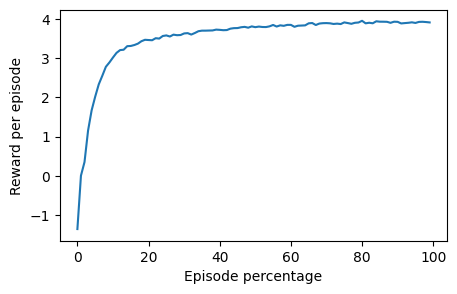

In [19]:
rewards = np.array(data_training['episode_reward']).reshape(100, -1)
mean_rewards = np.mean(rewards, axis = 1)
sem_rewards = np.std(rewards, axis = 1) / np.sqrt(len(rewards[0]))
plt.figure(figsize = (5, 3))
plt.plot(mean_rewards)
plt.fill_between(range(len(mean_rewards)), mean_rewards - sem_rewards, mean_rewards + sem_rewards, alpha = 0.2)
# plt.ylim((3, 4))
plt.xlabel('Episode percentage')
plt.ylabel('Reward per episode')
plt.show()

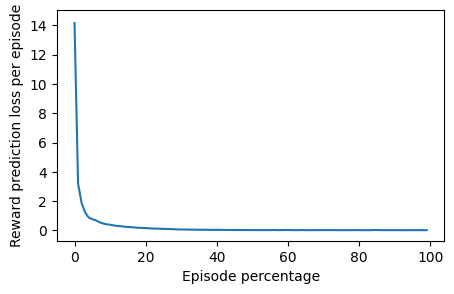

In [20]:
reward_prediction_loss = np.array(data_training['reward_pred_loss']).reshape(100, -1)
mean_reward_prediction_loss = np.mean(reward_prediction_loss, axis = 1)
sem_reward_prediction_loss = np.std(reward_prediction_loss, axis = 1) / np.sqrt(len(rewards[0]))
plt.figure(figsize = (5, 3))
plt.plot(mean_reward_prediction_loss)
plt.fill_between(range(len(mean_reward_prediction_loss)), mean_reward_prediction_loss - sem_reward_prediction_loss, mean_reward_prediction_loss + sem_reward_prediction_loss, alpha = 0.2)
# plt.ylim((0, 0.2))
plt.xlabel('Episode percentage')
plt.ylabel('Reward prediction loss per episode')
plt.show()

In [21]:
adj_dict = {
    0: [9, 27], 1: [22, 28], 2: [22, 10], 3: [2, 23],
    4: [14, 19], 5: [12, 21], 6: [2, 8], 7: [15, 31],
    8: [16, 20], 9: [11, 25], 10: [0, 30], 11: [5, 25],
    12: [0, 7], 13: [26, 28], 14: [13, 29], 15: [6, 29],
    16: [17, 19], 17: [21, 24], 18: [30, 31], 19: [13, 23],
    20: [3, 4], 21: [3, 8], 22: [7, 9], 23: [1, 18],
    24: [4, 11], 25: [6, 15], 26: [12, 18], 27: [5, 20],
    28: [1, 14], 29: [24, 26], 30: [17, 27], 31: [10, 16],
}
adj_matrix = np.zeros((32, 32))
for key, item in adj_dict.items():
    adj_matrix[key, item[0]] = 1
    adj_matrix[key, item[1]] = 1

env = GraphEnv(
    num_state = 32,
    reward_set = np.concatenate([np.repeat(1, 10), np.repeat(-1, 21), np.array([5])]),
    adj_matrix = adj_matrix,
)
env = MetaLearningWrapper(env)

In [22]:
def simulate(net, env, num_simulation, print_results = True):

    data_simulation = {
        'rewards': [],
        'max_cum_reward': [],
        'max_path': [],

        'stage_seqs': [],
        'state_seqs': [],
        'action_seqs': [],
        'reward_seqs': [],
        'value_seqs': [],
    }

    for i in range(num_simulation):

        stage_seq_episode = []
        state_seq_episode = []
        action_seq_episode = []
        reward_seq_episode = []
        value_seq_episode = []


        obs, info = env.reset()
        obs = torch.Tensor(obs).unsqueeze(dim = 0)

        max_cum_reward_episode, max_path_episode = env.graph.max_reward_path(env.state)
        if print_results:
            print('init state:', env.state)
            print('optimal actions:', max_cum_reward_episode, max_path_episode)
        
        done = False
        states_actor, states_critic = None, None
        
        with torch.no_grad():
            while not done:
                info_cache = info.copy()

                action, policy, log_prob, entropy, value, state_prediction, reward_prediction, states_actor, states_critic = net(obs, states_actor, states_critic, mask = info['mask'])
                action = torch.argmax(policy)

                obs, reward, done, truncated, info = env.step(action)
                obs = torch.Tensor(obs).unsqueeze(dim = 0)

                if print_results:
                    print(
                        'state:', info_cache['state'], '|',
                        'action:', action.item(), '|',
                        'reward:', reward, '|',
                        'timer:', env.timer, '|',
                        'done:', done, '|',
                    )
                stage_seq_episode.append(info_cache['stage'])
                state_seq_episode.append(info_cache['state'])
                action_seq_episode.append(action.item())
                reward_seq_episode.append(reward)
                value_seq_episode.append(value.item())
            
            action, policy, log_prob, entropy, value, state_prediction, reward_prediction, states_actor, states_critic = net(obs, states_actor, states_critic, mask = info['mask'])
            action = torch.argmax(policy)
            
            if print_results:
                print(
                    'state:', info['state'], '|',
                    # 'action:', action.item(), '|',
                    # 'reward:', reward, '|',
                    # 'timer:', env.timer, '|',
                    # 'done:', done, '|',
                )
                print('episode cum reward:', np.sum(reward_seq_episode))
                print()
            stage_seq_episode.append(info['stage'])
            state_seq_episode.append(info['state'])
            action_seq_episode.append(action.item())

            data_simulation['rewards'].append(env.graph.rewards)
            data_simulation['max_cum_reward'].append(max_cum_reward_episode)
            data_simulation['max_path'].append(max_path_episode)

            data_simulation['state_seqs'].append(stage_seq_episode)
            data_simulation['state_seqs'].append(state_seq_episode)
            data_simulation['action_seqs'].append(action_seq_episode)
            data_simulation['reward_seqs'].append(reward_seq_episode)
            data_simulation['value_seqs'].append(value_seq_episode)


    data_simulation['rewards'] = np.array(data_simulation['rewards'])
    data_simulation['max_cum_reward'] = np.array(data_simulation['max_cum_reward'])
    data_simulation['max_path'] = np.array(data_simulation['max_path'])
    data_simulation['stage_seqs'] = np.array(data_simulation['stage_seqs'])
    data_simulation['state_seqs'] = np.array(data_simulation['state_seqs'])
    data_simulation['action_seqs'] = np.array(data_simulation['action_seqs'])
    data_simulation['reward_seqs'] = np.array(data_simulation['reward_seqs'])
    data_simulation['value_seqs'] = np.array(data_simulation['value_seqs'])

    return data_simulation

In [23]:
data_simulation = simulate(net, env, num_simulation = 5000, print_results = True)

init state: 19
optimal actions: 5 [19, 13, 26, 18, 30, 17]
state: 19 | action: 2 | reward: 0.0 | timer: 1 | done: False |
state: 19 | action: 2 | reward: 0.0 | timer: 2 | done: False |
state: 19 | action: 2 | reward: 0.0 | timer: 3 | done: False |
state: 19 | action: 2 | reward: 0.0 | timer: 4 | done: False |
state: 19 | action: 2 | reward: 0.0 | timer: 5 | done: False |
state: 19 | action: 1 | reward: -1 | timer: 6 | done: False |
state: 23 | action: 1 | reward: 5 | timer: 7 | done: False |
state: 18 | action: 0 | reward: -1 | timer: 8 | done: False |
state: 30 | action: 1 | reward: 1 | timer: 9 | done: False |
state: 27 | action: 1 | reward: 1 | timer: 10 | done: True |
state: 20 |
episode cum reward: 5.0

init state: 1
optimal actions: 1 [1, 28, 14, 13, 26, 12]
state: 1 | action: 2 | reward: 0.0 | timer: 1 | done: False |
state: 1 | action: 2 | reward: 0.0 | timer: 2 | done: False |
state: 1 | action: 2 | reward: 0.0 | timer: 3 | done: False |
state: 1 | action: 2 | reward: 0.0 | ti

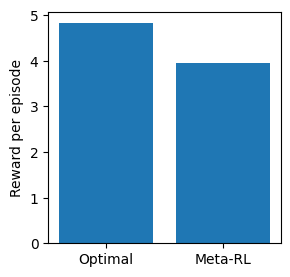

In [24]:
plt.figure(figsize = (3, 3))
plt.bar(['Optimal', 'Meta-RL'], [data_simulation['max_cum_reward'].mean(), data_simulation['reward_seqs'].sum(axis = 1).mean()])
plt.ylabel('Reward per episode')
plt.show()

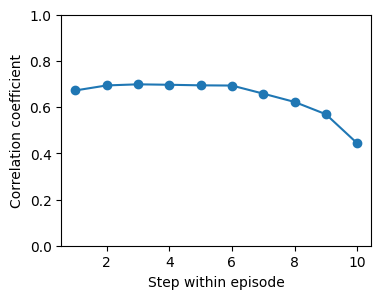

In [83]:
gamma = 0.9
t_total = 10
returns = np.zeros_like(data_simulation['reward_seqs'], dtype = float)

for t in range(t_total):
    returns[:, t] = np.sum(data_simulation['reward_seqs'][:, t:] * gamma ** np.arange(t_total - t), axis = 1)

coefficients = np.zeros(t_total)
for t in range(t_total):
    values_t = data_simulation['value_seqs'][:, t]
    returns_t = returns[:, t]
    coefficients[t] = np.corrcoef(values_t, returns_t)[0, 1]

plt.figure(figsize = (4, 3))
plt.plot(np.arange(1, t_total + 1), coefficients, marker = 'o')
plt.ylim((0, 1))
plt.xlabel('Step within episode')
plt.ylabel('Correlation coefficient')
plt.show()

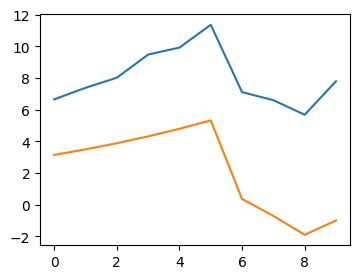

In [84]:
plt.figure(figsize = (4, 3))
plt.plot(data_simulation['value_seqs'][32, :])
plt.plot(returns[32, :])
plt.show()